# Model Analysis


## 1. Introduction

We now have some cleaned ML data, and a model trained on this data which can make some predictions.

This notebook will present the results - i.e. the predicted skin temperature - of this trained model, and compare with the observations and the ERA "predictions". 


### 1.1 Quick review 

The steps we took to get to this point are (see also `00. Summary.ipynb`):

1. Convert monthly ERA `.grib` files into hourly `NetCDF`, converting the longtiude to `long1` format in the process.

2. Join the ERA data with the MODIS data to produce a collection of hourly `.pkl` files.

3. Merge all hourly joined files into a single "cleaned ML data" source.

4. Train a NN on a subset of this data source - just 2018. Predictions are made on 2020. 2019 is left as a buffer or if we need a validation set.

---

### 1.2 Other useful info


The features used when training the model are as follows:


In [30]:

feature_names = [ 'sp', 'msl', 'u10', 'v10','t2m',
                  'aluvp', 'aluvd', 'alnip', 'alnid', 'cl',
                  'cvl', 'cvh', 'slt', 'sdfor', 'z', 'sd', 'sdor', 'isor', 'anor', 'slor',
                  'd2m', 'lsm', 'fal','skt'] 
import requests
import pandas as pd

r = requests.get("https://apps.ecmwf.int/codes/grib/json/").json()['parameters']

def param_name(x,r):
    try:
        d = next(item for item in r if item["param_shortName"] == x)
        name = d['param_name']
        units = d['units_name']
    except:
        #maybe naming convention is different
        name = 'Null'
        units = 'Null'
    
    return f'{x}: {name} : {units}'


for i in feature_names:
    print(param_name(i,r))

sp: Wind speed (SP) : m s**-1
msl: Mean sea level pressure : Pa
u10: Null : Null
v10: Null : Null
t2m: Null : Null
aluvp: UV visible albedo for direct radiation : (0 - 1)
aluvd: UV visible albedo for diffuse radiation : (0 - 1)
alnip: Near IR albedo for direct radiation : (0 - 1)
alnid: Near IR albedo for diffuse radiation : (0 - 1)
cl: Lake cover : (0 - 1)
cvl: Low vegetation cover : (0 - 1)
cvh: High vegetation cover : (0 - 1)
slt: Soil type : ~
sdfor: Standard deviation of filtered subgrid orography : m
z: Geopotential : m**2 s**-2
sd: Snow depth water equivalent : kg m**-2
sdor: Standard deviation of orography : m
isor: Anisotropy of sub-gridscale orography : ~
anor: Angle of sub-gridscale orography : radians
slor: Slope of sub-gridscale orography : ~
d2m: Null : Null
lsm: Land-sea mask : (0 - 1)
fal: Forecast albedo : (0 - 1)
skt: Skin temperature : K


---

## 2. Load the data

The predictions along with the trained model itself and the training history are in `/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ML_1647449098/`

These predictions are for all of 2020, on an hourly grain, across the entire Earth surface. 

Lets load the data, and create some extra columns to quantify the prediction errors

In [1]:
path = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ML_1647449098/' #Averaged
#path = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ML_1647513928/' #single

In [2]:
import pandas as pd
df = pd.read_pickle(path+'predictions.pkl')

#Create some new columns for the errors
df['error_ERA'] = df.MODIS_LST - df.t2m
df['error_ERA_abs'] = abs(df.MODIS_LST - df.t2m)

df['error_NN'] = df.MODIS_LST - df.predictions
df['error_NN_abs'] = abs(df.MODIS_LST - df.predictions)

#Surface some useful numbers
print('Absolute error:')
print('--------------------------------')
print("Mean, Median error from NN model:",df.error_NN_abs.mean(), df.error_NN_abs.median())
print("Mean, Median error from ERA5:    ", df.error_ERA_abs.mean(), df.error_ERA_abs.median())

print('Biased error:')
print('--------------------------------')
print("Mean, Median bias from NN model:",df.error_NN.mean(), df.error_NN.median())
print("Mean, Median bias from ERA5:    ", df.error_ERA.mean(), df.error_ERA.median())

Absolute error:
--------------------------------
Mean, Median error from NN model: 3.331174 2.5567932
Mean, Median error from ERA5:     6.8367443 5.0725403
Biased error:
--------------------------------
Mean, Median bias from NN model: 0.21679911 0.26815796
Mean, Median bias from ERA5:     4.656218 3.462738


In [3]:
df

latitude_ERA  longitude_ERA                time         t2m  \
71034945     -70.117048          45.75 2020-01-01 10:00:00  258.250977   
71034946     -70.117048          47.25 2020-01-01 10:00:00  257.209961   
71034947     -70.117048          48.00 2020-01-01 10:00:00  257.432617   
71034948     -70.117048          48.75 2020-01-01 10:00:00  257.778320   
71034949     -70.117048          49.50 2020-01-01 10:00:00  257.629883   
...                 ...            ...                 ...         ...   
105640205     70.117048          69.75 2020-12-30 09:00:00  241.386597   
105640206     70.117048          71.25 2020-12-30 09:00:00  242.644409   
105640207     70.117048          72.00 2020-12-30 09:00:00  243.597534   
105640208     70.117048          74.25 2020-12-30 09:00:00  239.439331   
105640209     70.117048          75.00 2020-12-30 09:00:00  239.302612   

            MODIS_LST  predictions  error_ERA  error_ERA_abs  error_NN  \
71034945   255.351456   255.842392  -2.899521       2.899521 -0.490936   
71034946   256.923279   254.734604  -0.286682       0.286682  2.188675   
71034947   256.583191   254.907318  -0.849426       0.849426  1.675873   
71034948   259.628265   255.388016   1.849945       1.849945  4.240250   
71034949   260.910400   255.088638   3.280518       3.280518  5.821762   
...               ...          ...        ...            ...       ...   
105640205  241.867874   241.499237   0.481277       0.481277  0.368637   
105640206  243.849625   242.699265   1.205215       1.205215  1.150360   
105640207  243.605469   243.284149   0.007935       0.007935  0.321320   
105640208  240.991898   239.575500   1.552567       1.552567  1.416397   
105640209  240.527832   239.364349   1.225220       1.225220  1.163483   

           error_NN_abs  
71034945       0.490936  
71034946       2.188675  
71034947       1.675873  
71034948       4.240250  
71034949       5.821762  
...                 ...  
105640205      0.368637  
105640206      1.150360  
105640207      0.321320  
105640208      1.416397  
105640209      1.163483  

[34605265 rows x 10 columns]

## 3. Visualize the data

Picture = 1000 words etc. etc. Here are some plots


In [52]:
import seaborn as sns
import matplotlib.pyplot as plt


def error_plot(df,x,grain):
    
    """
    Plotting function.
    df: data to plot
    x: What variable do you want the x-axis to be?
    grain: Precision of the x axis e.g. days. If int, then decimal precision
    relative: Boolean. Plot relative error or absolute error
    """

    
    
    
    
    #Some new columns used for plotting
    
    
    #Setup the x variable to plot.
    if x == 'time':
        df["X"] = df[x].dt.to_period(grain).dt.to_timestamp()
    else:
        df["X"] = df[x].round(grain) # Can also use .apply(lambda x: custom_round(x, base=2))
    
        
    #Group by
    df_plot = df.groupby(['X'],as_index=False).mean()
    
     #Setup plot env
    h,w = 20,20

    sns.set_theme(context='talk', 
                  style='ticks', 
                  palette='deep',
                  rc={'figure.figsize':(h,w)}
                  )

    
    #Figure
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(h,w))
    
    #Plot
    p = sns.lineplot(data=df_plot, x='X', y='error_NN_abs',ax=ax1,markers=True,label='NN')
    p = sns.lineplot(data=df_plot, x='X', y='error_ERA_abs',ax=ax1,markers=True,label='ERA')
    
    #Config
    ax1.set_xlabel('time', fontsize = 20)
    ax1.set_ylabel('Error [K]', fontsize = 20)


    

    #Other config
    ax1.legend().set_title(None)
    

        
import matplotlib.colors as mc
import matplotlib.colorbar as cb  
def plot_map(df,z,vmin,vmax,cmap,save):
    
    #Get all data as vectors
    x = df.longitude_ERA
    y = df.latitude_ERA
    z1 = df[z]
    
    #Scatter plot it
    # init the figure
    fig,[ax,cax] = plt.subplots(1,2, gridspec_kw={"width_ratios":[50,1]},figsize=(30, 20))

    
    norm = mc.Normalize(vmin=vmin, vmax=vmax)

    cb1 = cb.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
    
    
    sc = ax.scatter(x, y,
               s=1,
               c=cmap(norm(z1)),
               linewidths=1, alpha=.7
               )

    ax.set_title(z)
    
    if save is True:
        plt.savefig('example_image.png')
    plt.show()

## Error vs time

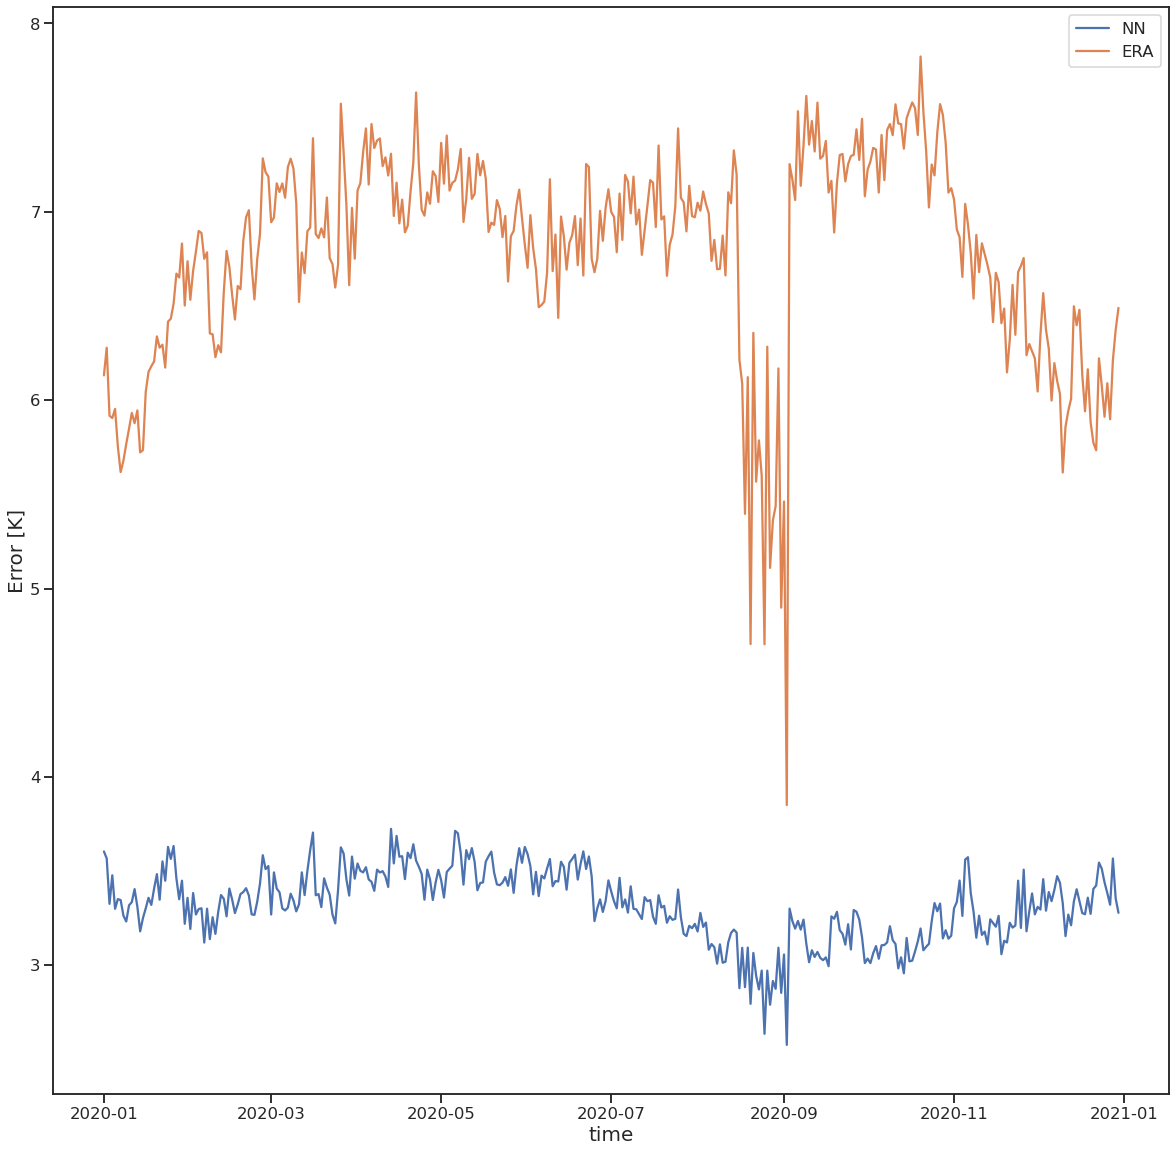

In [30]:
error_plot(df,'time','D')

## Error map

Average over time 


In [31]:
%%time
#Group by lat/long i.e. average over time
ds_map = df.groupby(['latitude_ERA', 'longitude_ERA'],as_index=False).mean()


CPU times: user 3.16 s, sys: 452 ms, total: 3.61 s
Wall time: 3.61 s


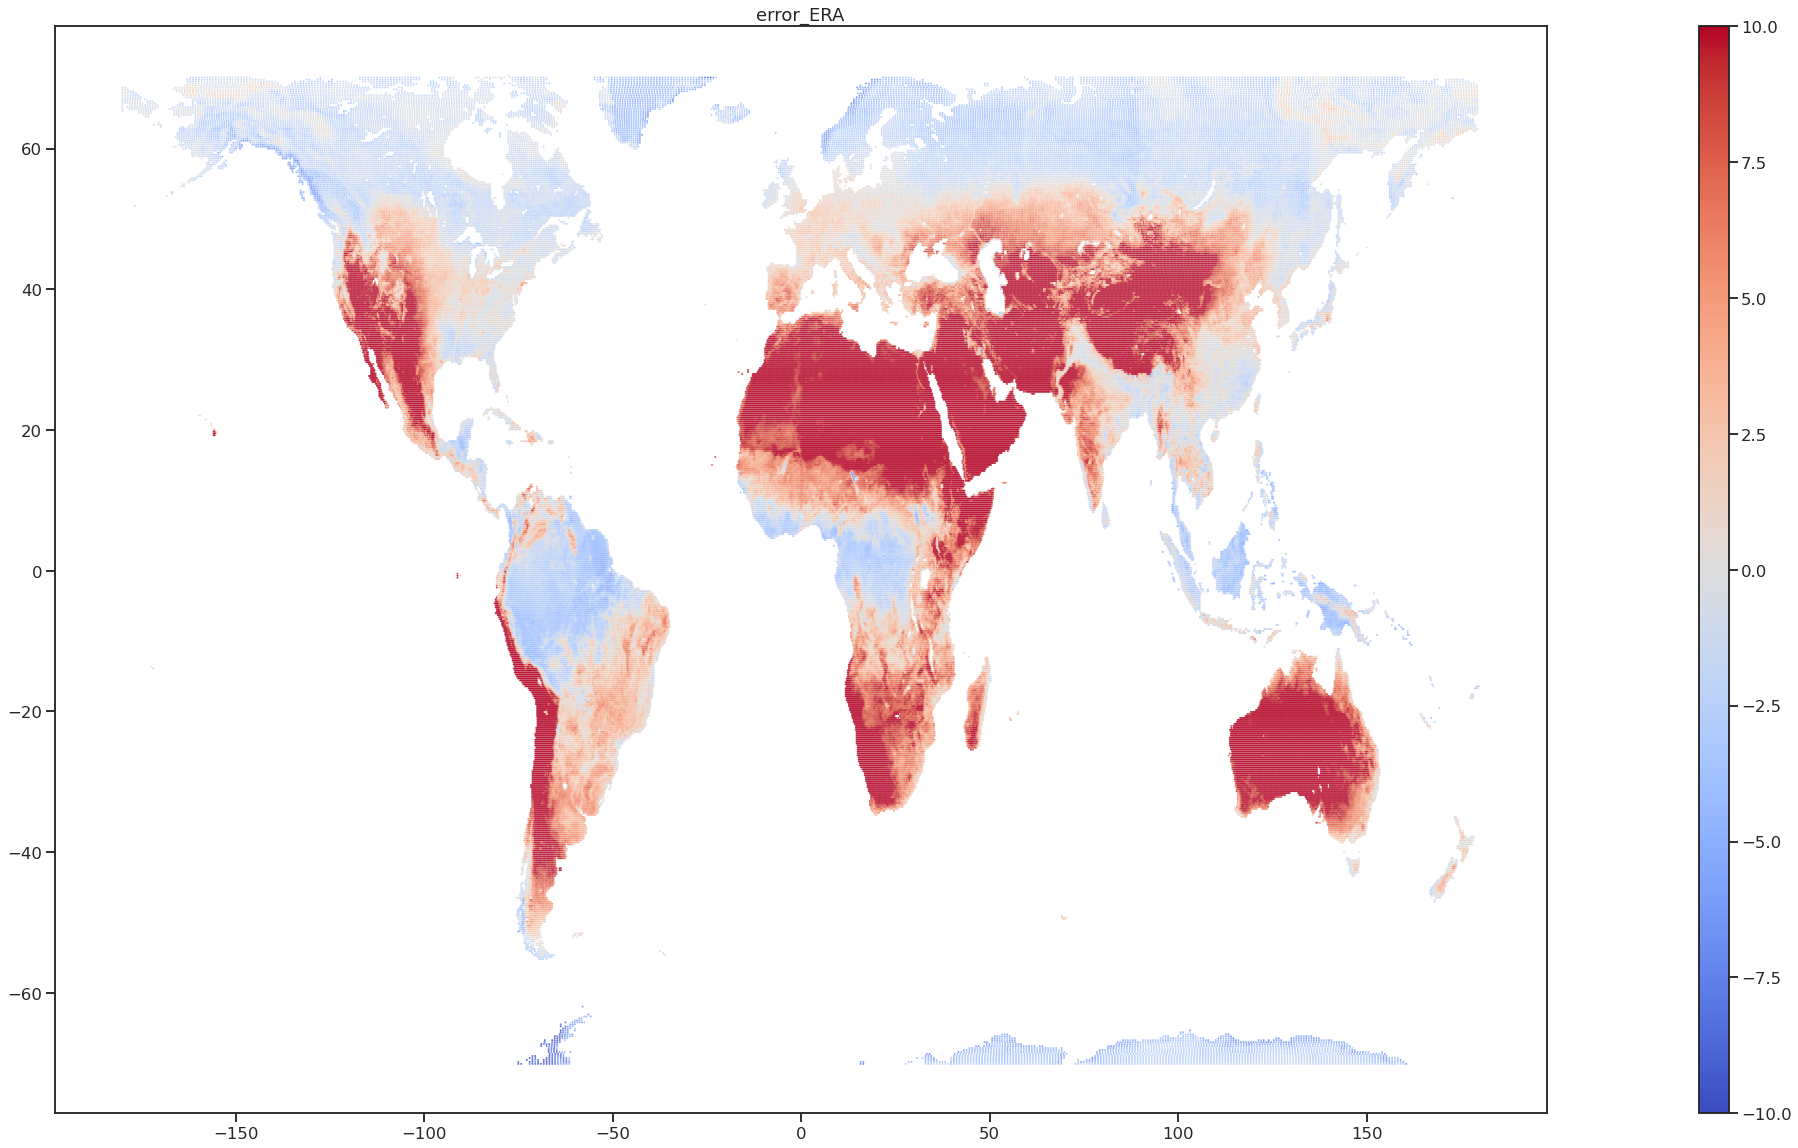

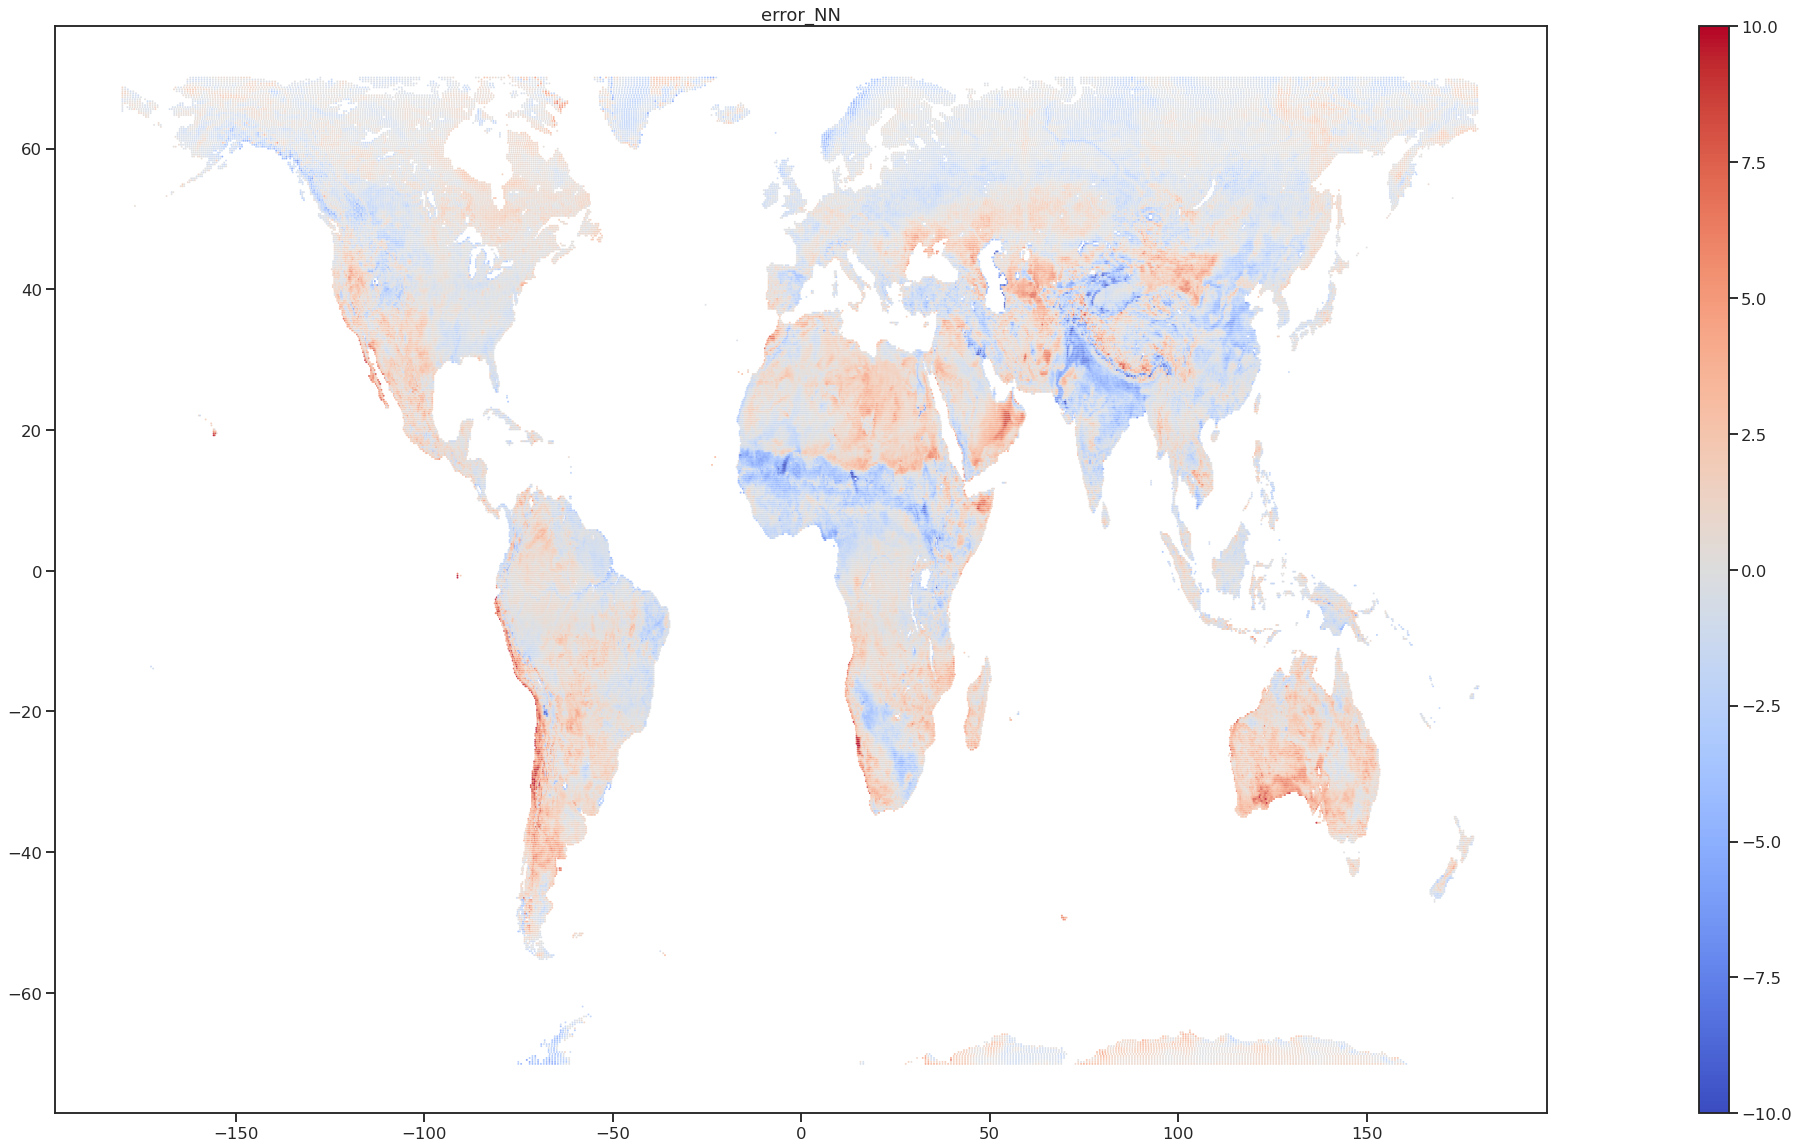

In [53]:
plot_map(ds_map,'error_ERA',vmin=-10,vmax=10,cmap = plt.cm.coolwarm,save=True)
plot_map(ds_map,'error_NN',vmin=-10,vmax=10,cmap = plt.cm.coolwarm,save=False)

We can also plot the absolute error with a sequantial cmap:

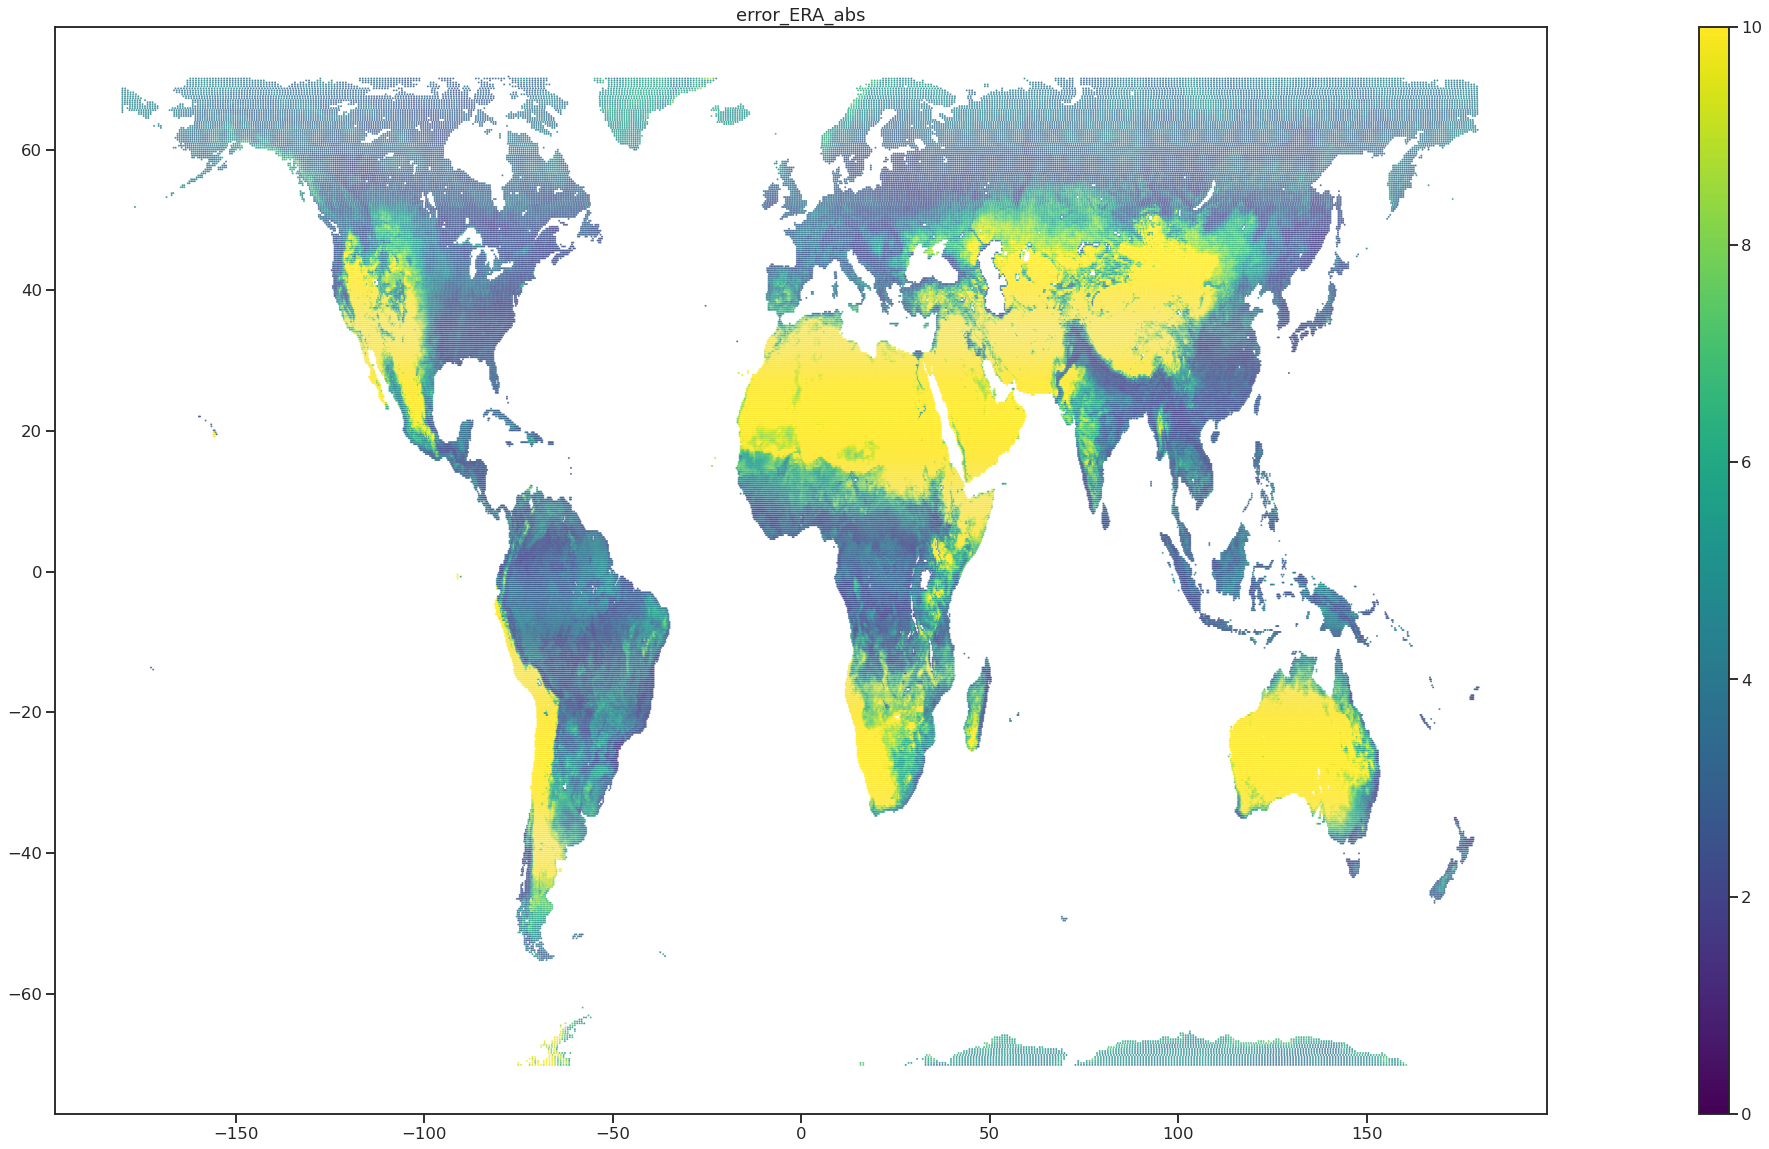

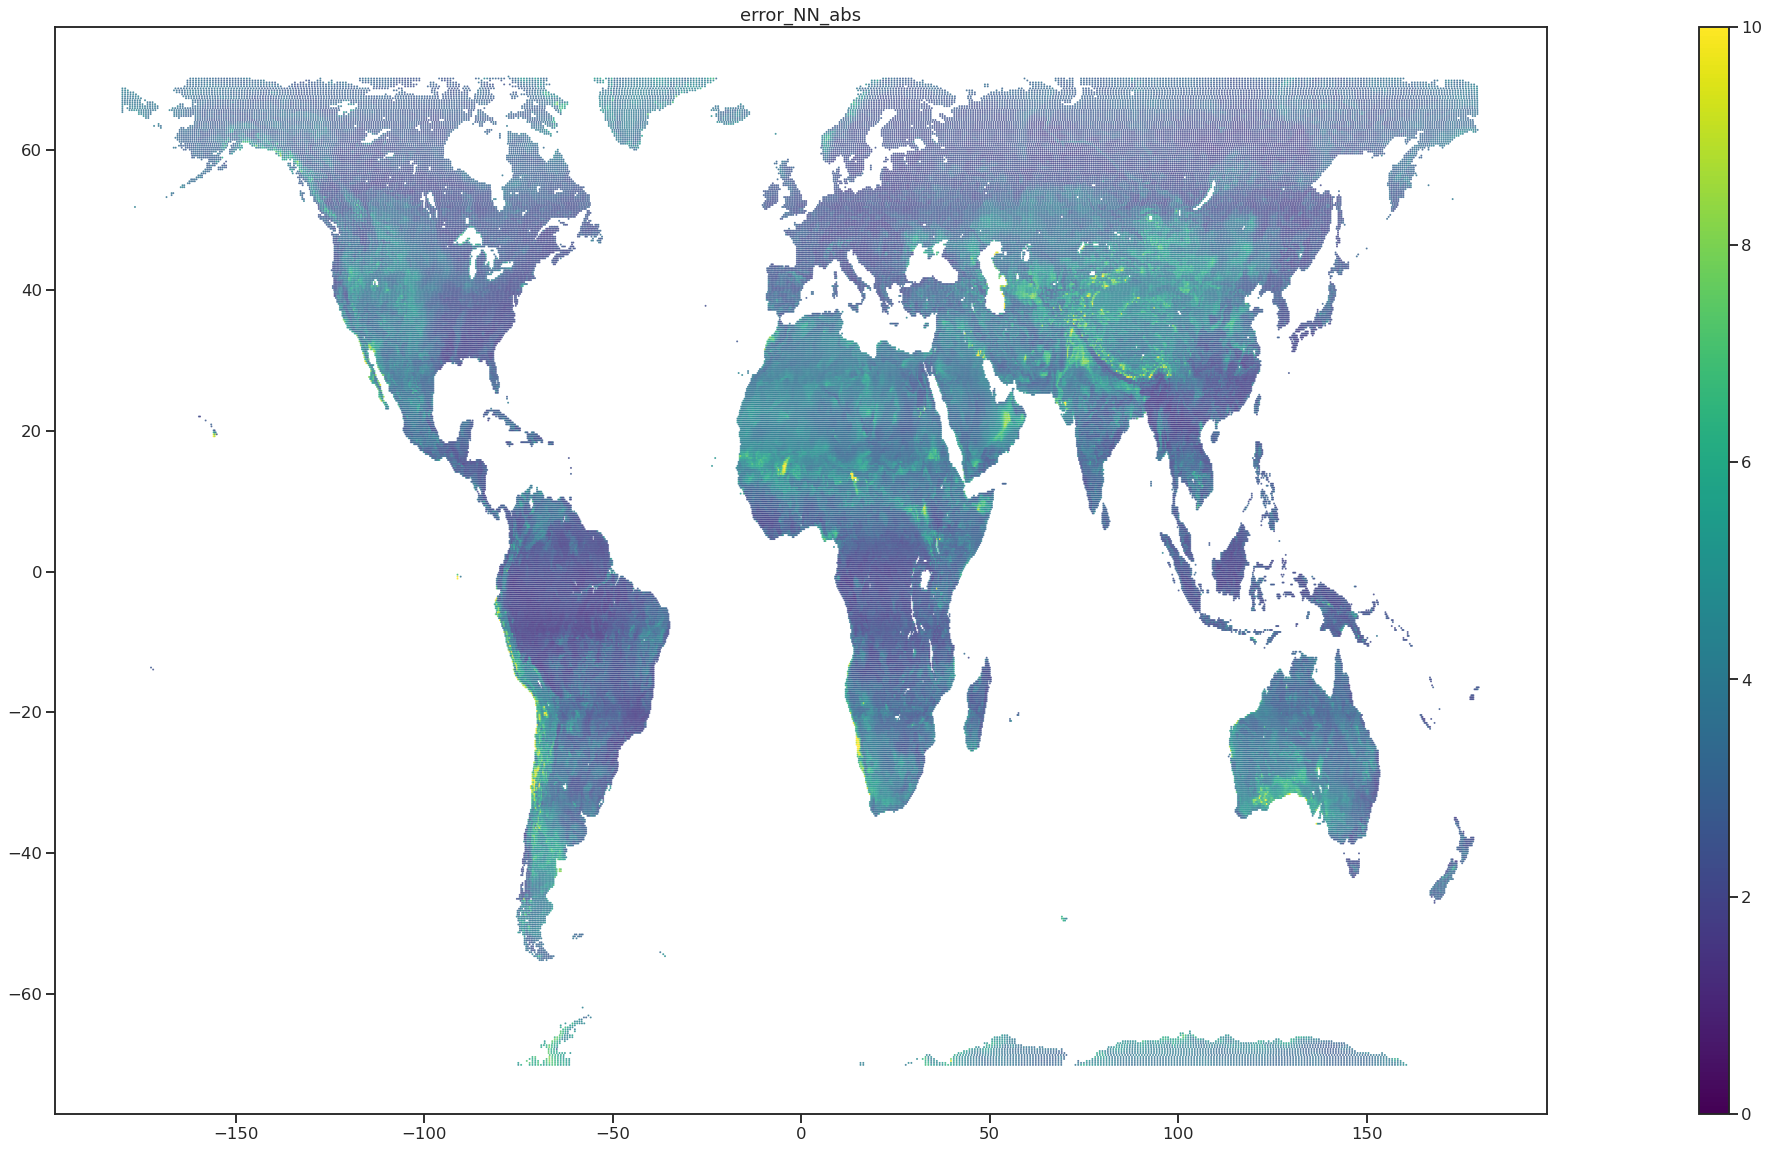

In [8]:
plot_map(ds_map,'error_ERA_abs',vmin=0,vmax=10,cmap=plt.cm.viridis)
plot_map(ds_map,'error_NN_abs',vmin=0,vmax=10,cmap=plt.cm.viridis)

(0.0, 4000000.0)

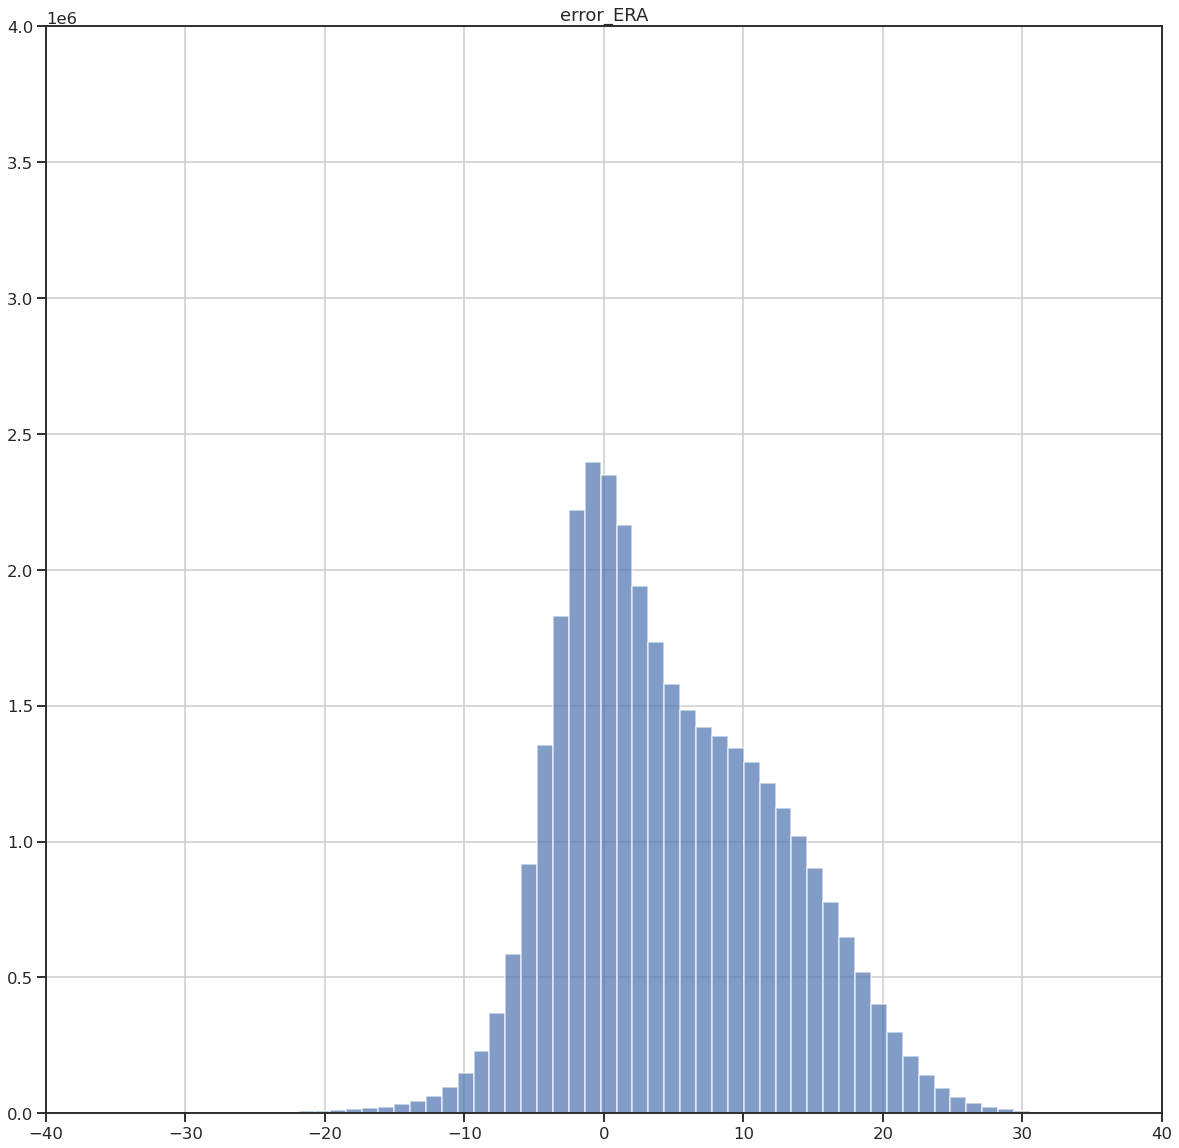

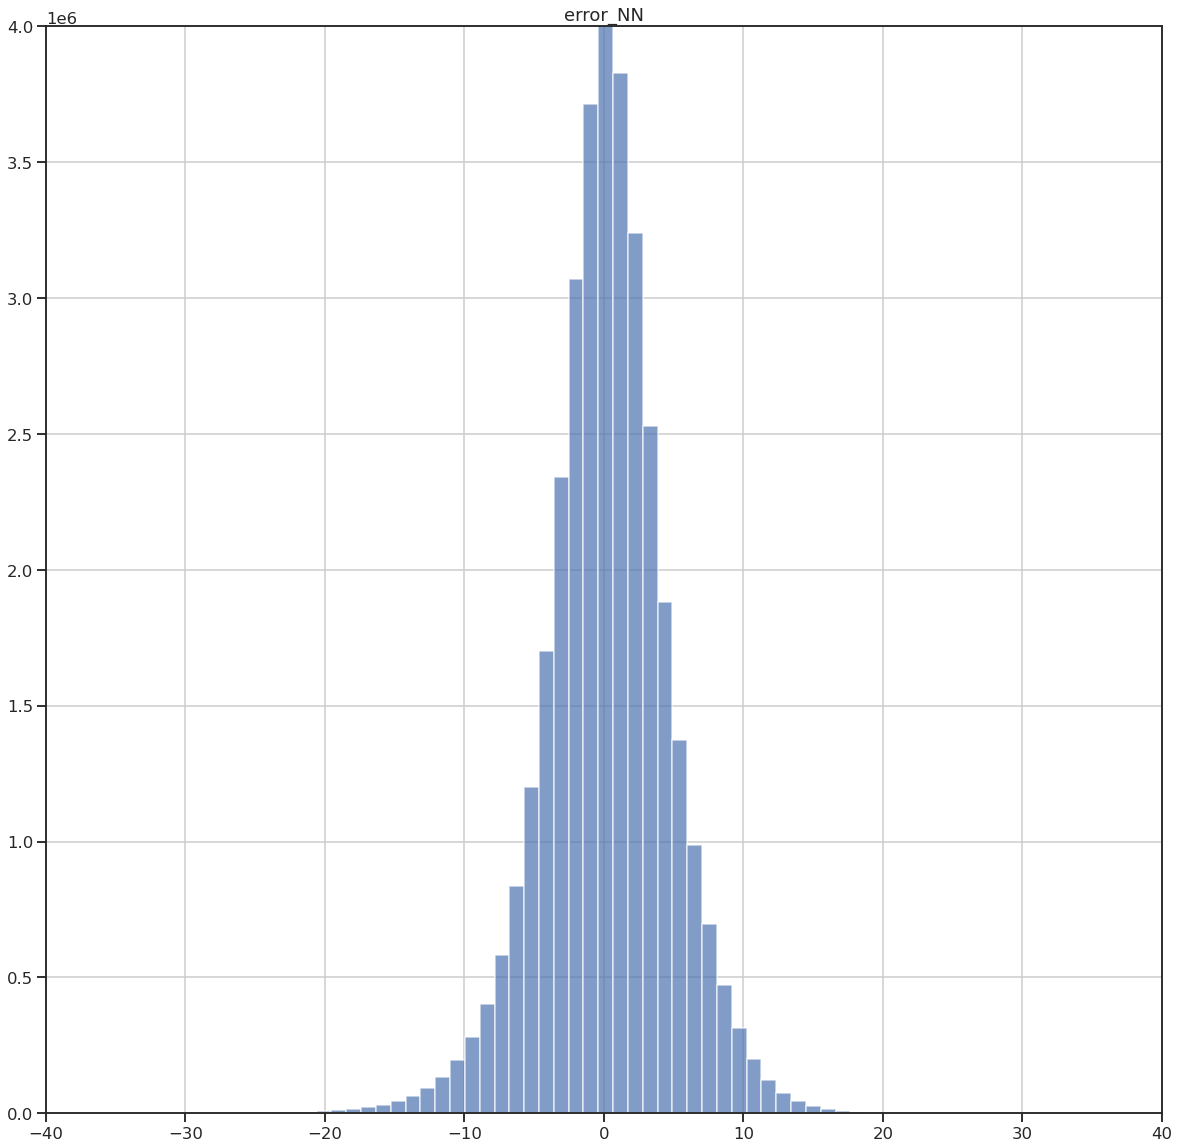

In [45]:
ax1 = df.hist(column='error_ERA',bins=100, alpha=0.7)
ax2 = df.hist(column='error_NN',bins=100, alpha=0.7)

ax1[0][0].set_xlim((-40, 40))
ax1[0][0].set_ylim((0, 4e6))


ax2[0][0].set_xlim((-40, 40))
ax2[0][0].set_ylim((0, 4e6))





---


# Appendix










It is also useful to be able to take an average over a specified time period:

In [17]:
df_month = df.copy()
df_month["time_month"] = df_month['time'].dt.to_period('M').dt.to_timestamp()
ds_map_month = df_month.groupby(['latitude_ERA', 'longitude_ERA','time_month'],as_index=False).mean()




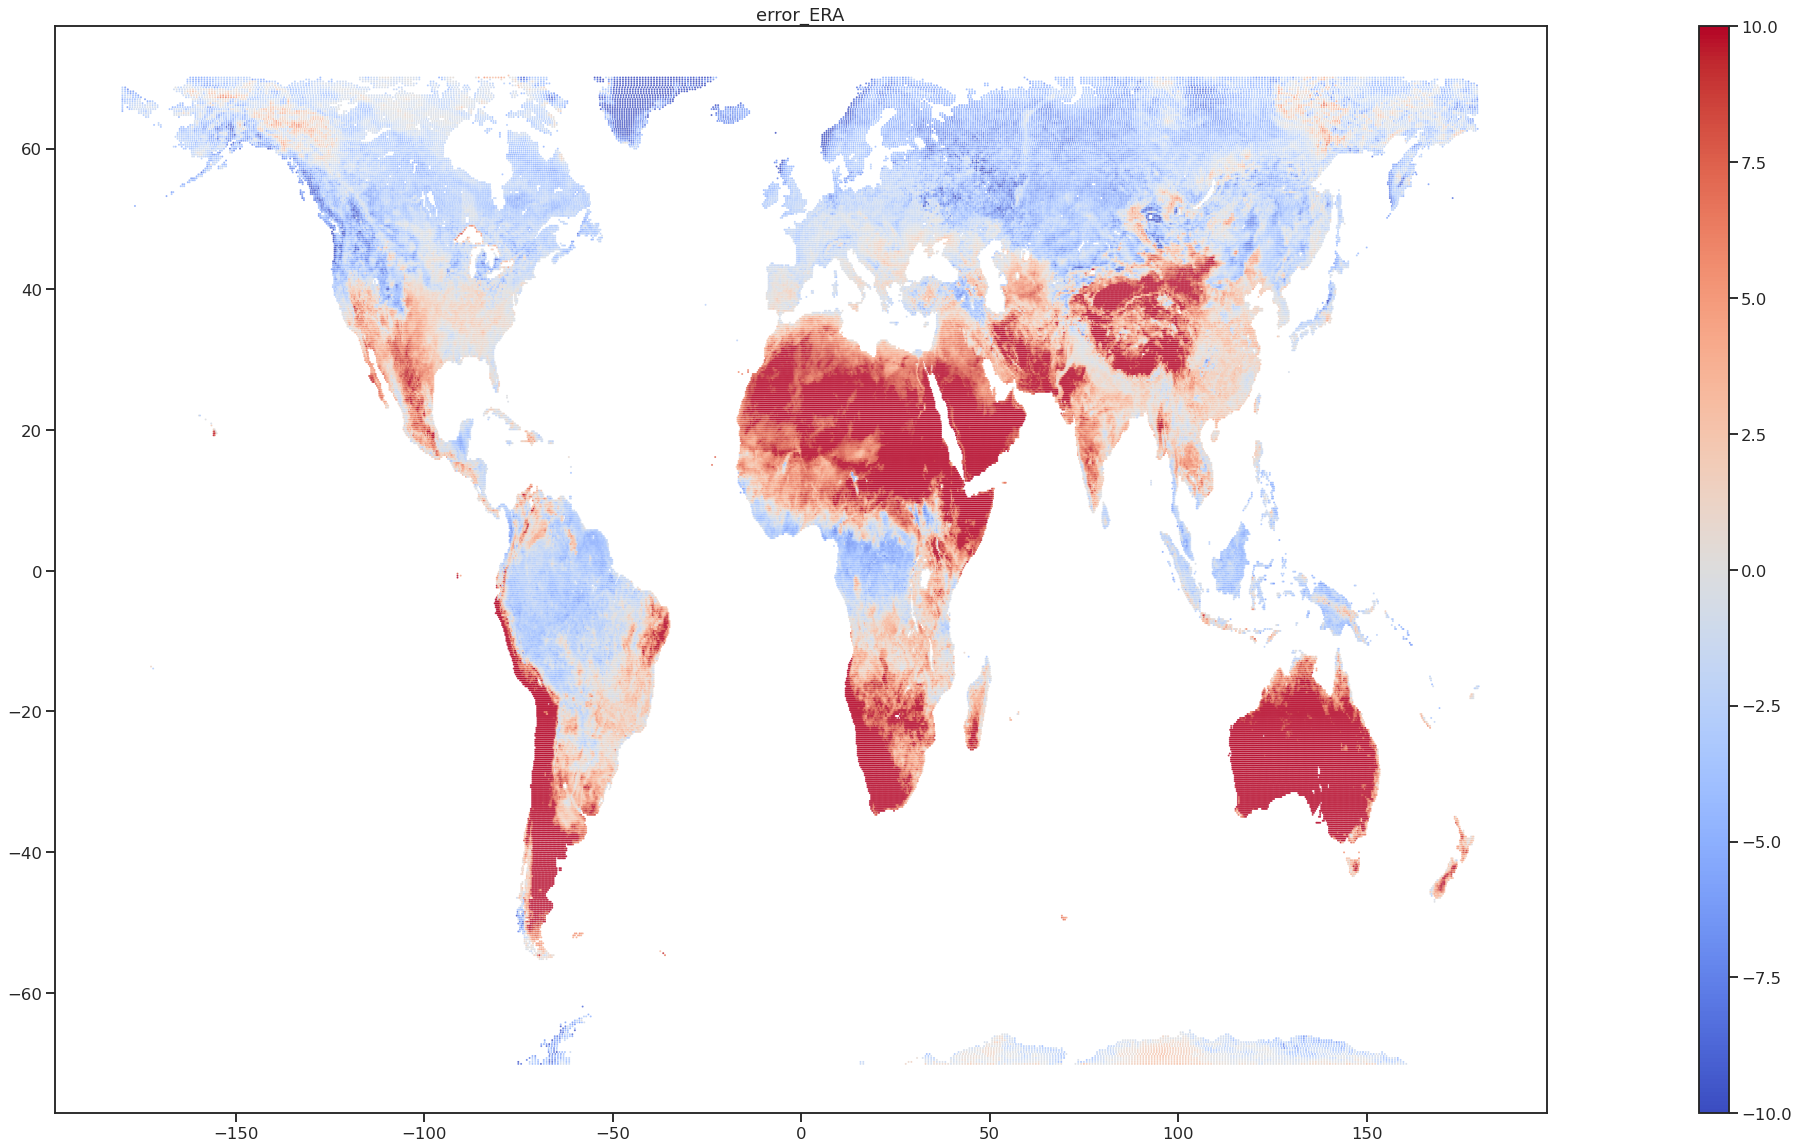

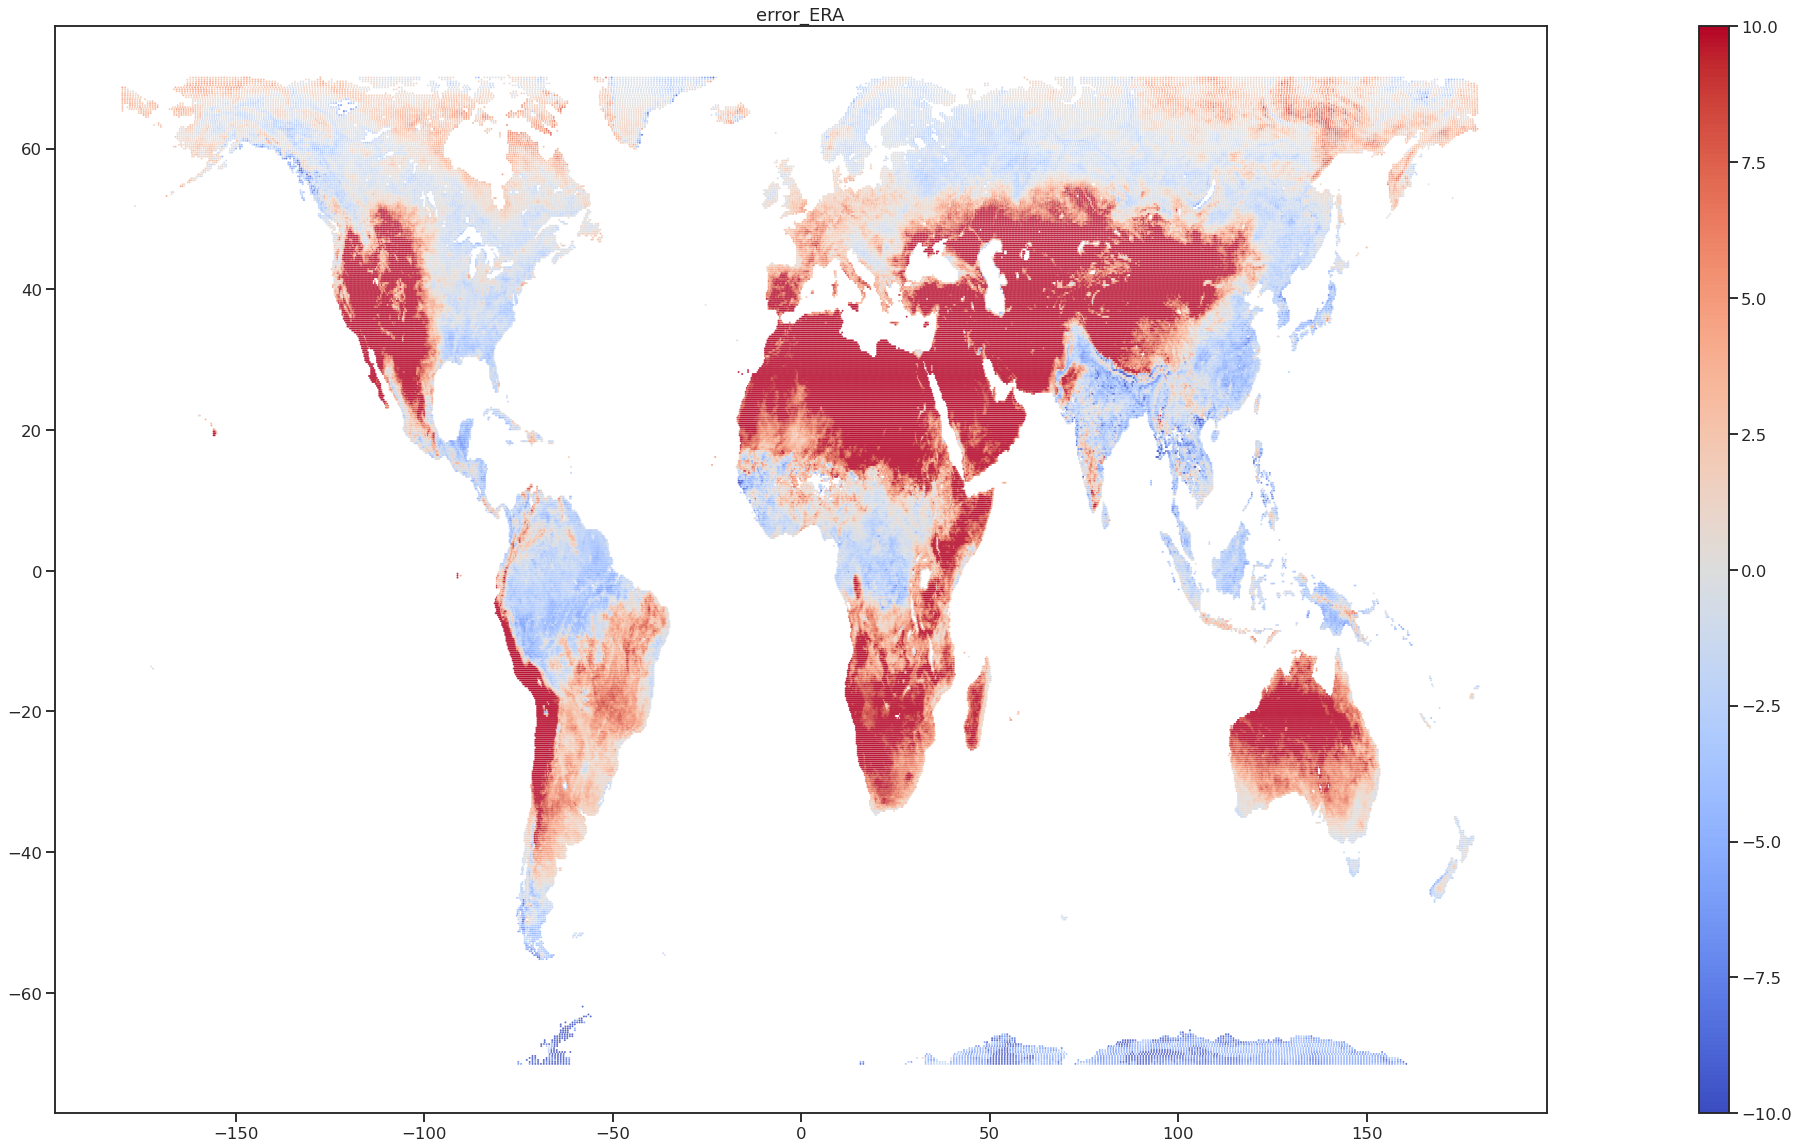

In [26]:
df_plot = ds_map_month.query('time_month == "2020-01-01"')
plot_map(df_plot,'error_ERA',vmin=-10,vmax=10,cmap = plt.cm.coolwarm)


df_plot = ds_map_month.query('time_month == "2020-08-01"')
plot_map(df_plot,'error_ERA',vmin=-10,vmax=10,cmap = plt.cm.coolwarm)

---

# Appendix


## A1 Model Training

We can also look at how the model trained:

In [10]:
import json
with open(path+'history.json') as f:
    d = json.load(f)


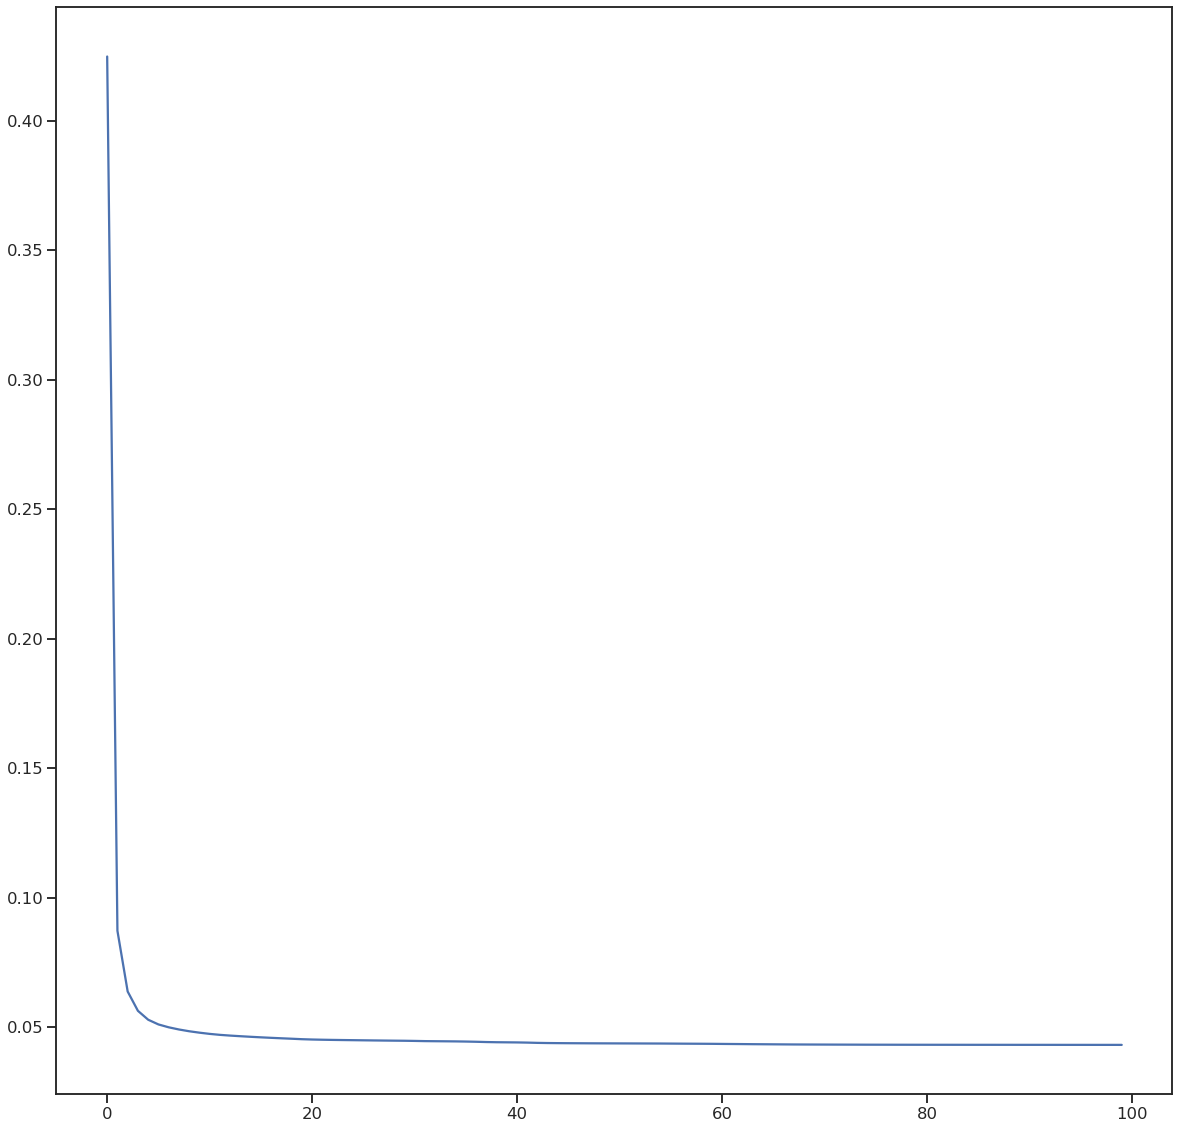

In [11]:
import numpy as np
y = d['loss']
x = np.arange(len(y))

fig = plt.figure(figsize=(20, 20))
plt.plot(x,y)
#plt.xscale('log')
#plt.yscale('log')

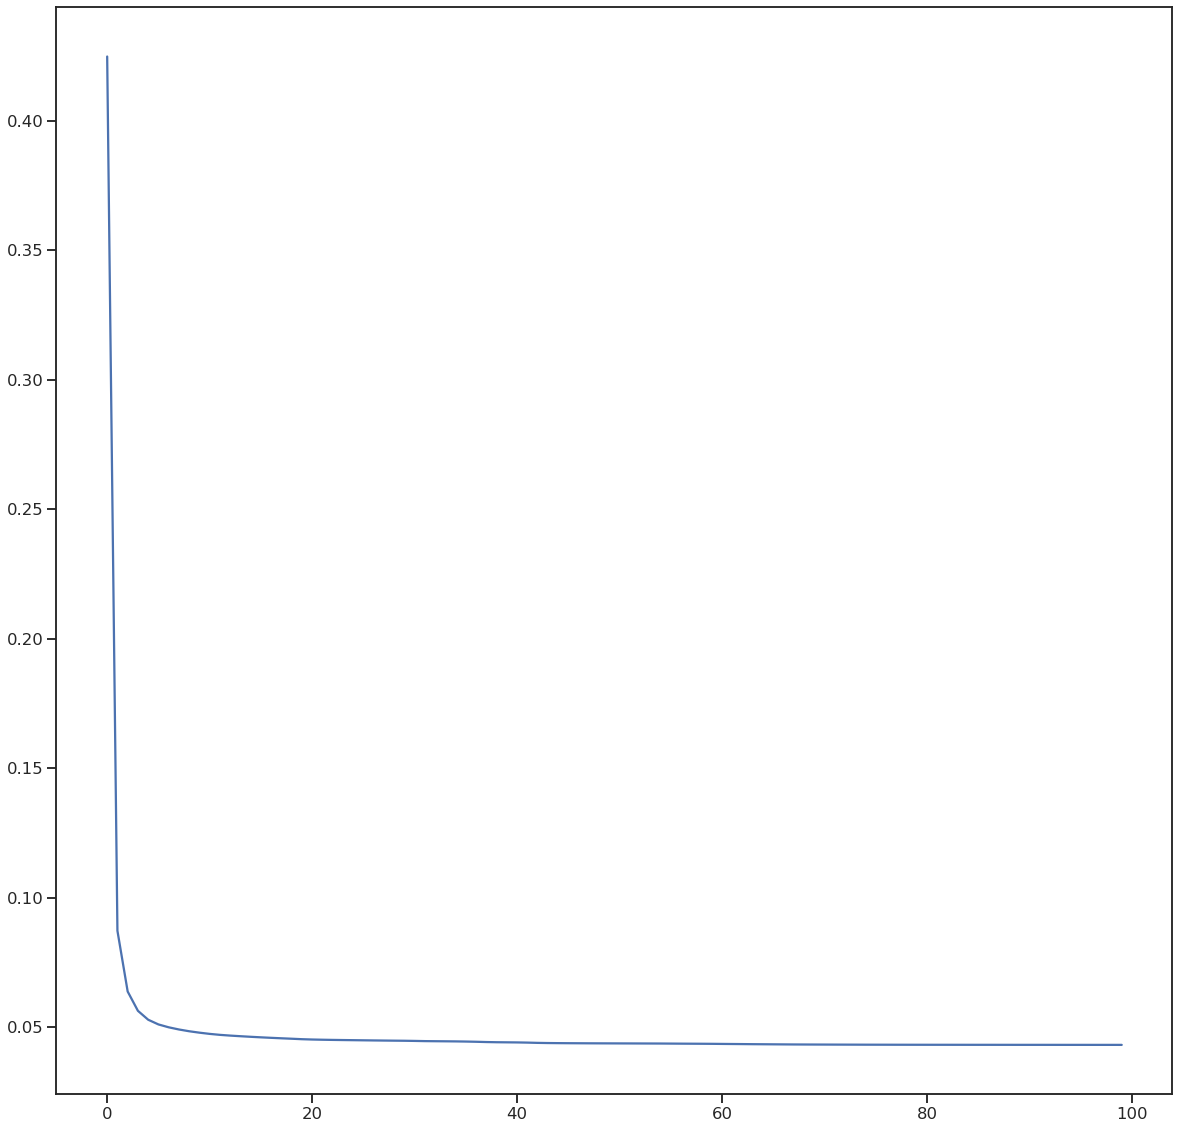

In [12]:
path1 = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ML_1647513928/' #single
with open(path+'history.json') as f:
    d = json.load(f)

import numpy as np
y = d['loss']
x = np.arange(len(y))

fig = plt.figure(figsize=(20, 20))
plt.plot(x,y)


## A2 Time slice

In [13]:
df_tmp = df.copy()

In [14]:
df_tmp = df.copy()
df_tmp['error_ERA'] = abs(df_tmp.MODIS_LST - df_tmp.t2m)
df_tmp['error_NN'] = abs(df_tmp.MODIS_LST - df_tmp.predictions)
df_tmp['error_ERA_rel'] = abs(df_tmp.MODIS_LST - df_tmp.t2m) / df_tmp.MODIS_LST
df_tmp['error_NN_rel'] = abs(df_tmp.MODIS_LST - df_tmp.predictions) / df_tmp.MODIS_LST
df["time_daily"] = df['time'].dt.to_period('D').dt.to_timestamp()
ds_map = df_tmp.groupby(['latitude_ERA', 'longitude_ERA','time_daily'],as_index=False).mean()

KeyError: 'time_daily'

In [ ]:
all_days = np.unique(df["time_daily"])

In [ ]:
ti = all_days[3]

In [ ]:
ti

In [ ]:
%matplotlib notebook

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [ ]:
%matplotlib widget

In [ ]:
fig, ax = plt.subplots()
line, = ax.plot([])     # A tuple unpacking to unpack the only plot
ax.set_xlim(0, 2*np.pi)
ax.set_ylim(-1.1, 1.1)

In [ ]:
import xarray as xr


In [ ]:
sat_xr.data.count()

In [ ]:
import numpy as np
sat_xr = xr.open_dataarray(f'/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/MODIS/aquaDay_errorGTE03K_04km_2020-06-25.tif',engine="rasterio")
np.count_nonzero(~np.isnan(sat_xr.data)) / 1e6

In [ ]:
sat_xr

In [ ]:
import numpy as np
sat_xr = xr.open_dataarray(f'/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/MODIS/aquaDay_errorGTE03K_04km_2020-08-25.tif',engine="rasterio")
np.count_nonzero(~np.isnan(sat_xr.data)) / 1e6

In [ ]:
sat_xr

In [ ]:
f = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/ERA_skin/sfc_skin_unstructured_2018_01.grib'
ds = xr.open_dataset(f,engine='cfgrib',filter_by_keys={'typeOfLevel': 'surface'})

In [ ]:
ds